In [0]:
# Global data variables
SANDBOX_NAME = # Sandbox Name
DATA_PATH = "/data/sandboxes/" + SANDBOX_NAME + "/data/data/" 

In [0]:
# Global data variables

DATA_PATH = "/content/drive/My Drive/Data/"

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.2.1-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
from pyspark.sql import functions as F

 

# Análisis de Datos Exploratorio

Lo pasos mas típicos en el análisis de datos exploratorio son los siguientes:

* Análisis Univariante
    * Tecnicas numéricas
    * Técnicas gráficas
    
* Análisis Multivariante
    * Técnicas numéricas
    * Técnicas gráficas
    
* Detección de outliers

* Tests de hipótesis

En el caso de Spark es menos común utilizar técnicas gráficas ya que muchas de estas requieren tener todos los datos en el driver. Más adelante se mostrarán formas de precalcular en Spark los datos de las gráficas o de realizar muestreos para su representación.



## Análisis Univariante
### Variables cuantitativas

Las métricas clásicas para variables cuantitativas son: media, desviación, máximo, mínimo, mediana y quartiles.

In [0]:
from pyspark.sql import functions as F

In [0]:
pokemon_df = spark.read.csv(DATA_PATH + 'pokemon.csv', sep=',', header=True, inferSchema=True)

In [0]:
pokemon_df = pokemon_df.withColumnRenamed('Sp. Atk', 'Sp Atk').withColumnRenamed('Sp. Def', 'Sp Def')

In [0]:
pokemon_df.show(3)

+---+---------+------+------+---+------+-------+------+------+-----+----------+---------+
|  #|     Name|Type 1|Type 2| HP|Attack|Defense|Sp Atk|Sp Def|Speed|Generation|Legendary|
+---+---------+------+------+---+------+-------+------+------+-----+----------+---------+
|  1|Bulbasaur| Grass|Poison| 45|    49|     49|    65|    65|   45|         1|    false|
|  2|  Ivysaur| Grass|Poison| 60|    62|     63|    80|    80|   60|         1|    false|
|  3| Venusaur| Grass|Poison| 80|    82|     83|   100|   100|   80|         1|    false|
+---+---------+------+------+---+------+-------+------+------+-----+----------+---------+
only showing top 3 rows



In [0]:
pokemon_df.dtypes

[('#', 'int'),
 ('Name', 'string'),
 ('Type 1', 'string'),
 ('Type 2', 'string'),
 ('HP', 'int'),
 ('Attack', 'int'),
 ('Defense', 'int'),
 ('Sp Atk', 'int'),
 ('Sp Def', 'int'),
 ('Speed', 'int'),
 ('Generation', 'int'),
 ('Legendary', 'boolean')]



Primero identifica variables cualitativas y cuantitativas.

In [0]:
quantitative_vars = [c for c,t in pokemon_df.dtypes if t in ['int', 'double']]
qualitative_vars = [c for c,t in pokemon_df.dtypes if t in ['boolean', 'string']]

In [0]:
quantitative_vars

['#', 'HP', 'Attack', 'Defense', 'Sp Atk', 'Sp Def', 'Speed', 'Generation']

In [0]:
qualitative_vars

['Name', 'Type 1', 'Type 2', 'Legendary']

In [0]:
pokemon_df.describe().show()

+-------+------------------+------------------+------+------+------------------+-----------------+------------------+----------------+-----------------+------------------+------------------+
|summary|                 #|              Name|Type 1|Type 2|                HP|           Attack|           Defense|          Sp Atk|           Sp Def|             Speed|        Generation|
+-------+------------------+------------------+------+------+------------------+-----------------+------------------+----------------+-----------------+------------------+------------------+
|  count|               800|               799|   800|   414|               800|              800|               800|             800|              800|               800|               800|
|   mean|             400.5|              null|  null|  null|          69.25875|         79.00125|           73.8425|           72.82|          71.9025|           68.2775|           3.32375|
| stddev|231.08440016582685|              nul

 

Calcula métricas para una única columna

In [0]:
pokemon_df.select(F.avg('Attack')).first()

Row(avg(Attack)=79.00125)

In [0]:
pokemon_df.select(F.avg('Attack')).first()[0]

79.00125

In [0]:
pokemon_df.select(F.avg('Attack')).first()[0]

79.00125

In [0]:
pokemon_df.select((F.max('HP') - F.min('HP')).alias('range')).show()

+-----+
|range|
+-----+
|  254|
+-----+



In [0]:
pokemon_df.select(F.avg('Attack'), F.max('Attack'), F.min('Attack')).first()

Row(avg(Attack)=79.00125, max(Attack)=190, min(Attack)=5)

In [0]:
pokemon_df.select(F.avg('Attack').alias('avg_attack'), 
                  F.max('Attack').alias('max_attack'), 
                  F.min('Attack').alias('min_attack')).first()

Row(avg_attack=79.00125, max_attack=190, min_attack=5)



Es importante recordar que en Spark hay que juntar el máximo número de operaciones antes de realizar una acción. Por tanto para calcular las métricas de todas las columnas es mejor intentar hacerlo en la misma transformación.



Una acción por columna

In [0]:
%%time

for col in quantitative_vars:
    avg = pokemon_df.select(F.avg(col)).first()[0]
    print(col, avg)

# 400.5
HP 69.25875
Attack 79.00125
Defense 73.8425
Sp Atk 72.82
Sp Def 71.9025
Speed 68.2775
Generation 3.32375
CPU times: user 38.4 ms, sys: 17 ms, total: 55.4 ms
Wall time: 1.32 s




Una acción para todas las columnas. Se pueden definir las operaciones a realizar en una lista y pasársela al método `select`.

In [0]:
[F.avg(col) for col in quantitative_vars]  # esto no opera sobre el dataframe, es una expresión

[Column<b'avg(#)'>,
 Column<b'avg(HP)'>,
 Column<b'avg(Attack)'>,
 Column<b'avg(Defense)'>,
 Column<b'avg(Sp Atk)'>,
 Column<b'avg(Sp Def)'>,
 Column<b'avg(Speed)'>,
 Column<b'avg(Generation)'>]

In [0]:
%%time 

pokemon_df.select([F.avg(col) for col in quantitative_vars]).show()

+------+--------+-----------+------------+-----------+-----------+----------+---------------+
|avg(#)| avg(HP)|avg(Attack)|avg(Defense)|avg(Sp Atk)|avg(Sp Def)|avg(Speed)|avg(Generation)|
+------+--------+-----------+------------+-----------+-----------+----------+---------------+
| 400.5|69.25875|   79.00125|     73.8425|      72.82|    71.9025|   68.2775|        3.32375|
+------+--------+-----------+------------+-----------+-----------+----------+---------------+

CPU times: user 8.08 ms, sys: 1.79 ms, total: 9.87 ms
Wall time: 466 ms




Para calcular multiples métricas en multiples columnas de forma eficiente se pueden juntar listas de operaciones.

In [0]:
avgs = [F.avg(col).alias('avg_' + col) for col in quantitative_vars]
maxs = [F.max(col).alias('max_' + col) for col in quantitative_vars]
mins = [F.min(col).alias('min_' + col) for col in quantitative_vars]
stds = [F.stddev(col).alias('std_' + col) for col in quantitative_vars]

In [0]:
operations = avgs + stds + maxs + mins 
operations

[Column<b'avg(#) AS `avg_#`'>,
 Column<b'avg(HP) AS `avg_HP`'>,
 Column<b'avg(Attack) AS `avg_Attack`'>,
 Column<b'avg(Defense) AS `avg_Defense`'>,
 Column<b'avg(Sp Atk) AS `avg_Sp Atk`'>,
 Column<b'avg(Sp Def) AS `avg_Sp Def`'>,
 Column<b'avg(Speed) AS `avg_Speed`'>,
 Column<b'avg(Generation) AS `avg_Generation`'>,
 Column<b'stddev_samp(#) AS `std_#`'>,
 Column<b'stddev_samp(HP) AS `std_HP`'>,
 Column<b'stddev_samp(Attack) AS `std_Attack`'>,
 Column<b'stddev_samp(Defense) AS `std_Defense`'>,
 Column<b'stddev_samp(Sp Atk) AS `std_Sp Atk`'>,
 Column<b'stddev_samp(Sp Def) AS `std_Sp Def`'>,
 Column<b'stddev_samp(Speed) AS `std_Speed`'>,
 Column<b'stddev_samp(Generation) AS `std_Generation`'>,
 Column<b'max(#) AS `max_#`'>,
 Column<b'max(HP) AS `max_HP`'>,
 Column<b'max(Attack) AS `max_Attack`'>,
 Column<b'max(Defense) AS `max_Defense`'>,
 Column<b'max(Sp Atk) AS `max_Sp Atk`'>,
 Column<b'max(Sp Def) AS `max_Sp Def`'>,
 Column<b'max(Speed) AS `max_Speed`'>,
 Column<b'max(Generation) AS `m

In [0]:
results = pokemon_df.select(operations).first()

for col in quantitative_vars:
    
    avg = results['avg_' + col]
    std = results['std_' + col]
    maxi = results['max_' + col]
    mini = results['min_' + col]
    
    print('{}: avg={}, std={}, min={}, max={}'.format(col, round(avg, 2), round(std, 2), mini, maxi))

#: avg=400.5, std=231.08, min=1, max=800
HP: avg=69.26, std=25.53, min=1, max=255
Attack: avg=79.0, std=32.46, min=5, max=190
Defense: avg=73.84, std=31.18, min=5, max=230
Sp Atk: avg=72.82, std=32.72, min=10, max=194
Sp Def: avg=71.9, std=27.83, min=20, max=230
Speed: avg=68.28, std=29.06, min=5, max=180
Generation: avg=3.32, std=1.66, min=1, max=6




__Mediana y cuantiles__

El caso de los cuantiles es un poco especial ya que requieren la ordenación de todo el DataFrame en base a una columna, por tanto no se pueden calcular los cuantiles de varias variables a la vez. Además, el método `approxQuantile` es una **acción**.

In [0]:
median = pokemon_df.approxQuantile('Defense', [0.5], relativeError=0.01)[0]
median

70.0

In [0]:
pokemon_df.approxQuantile('Defense', [0.25, 0.5, 0.75], relativeError=0.01)

[50.0, 70.0, 90.0]

In [0]:
q1, median, q3 = pokemon_df.approxQuantile('Defense', [0.25, 0.5, 0.75], relativeError=0.01)

In [0]:
q1

50.0

In [0]:
median

70.0

In [0]:
q3

90.0

In [0]:
iqr = q3 - q1  # Rango intercuantil
iqr

40.0



### Variables cualitativas

Para variables cualitativas se calculan tablas de frequencia.

In [0]:
pokemon_df.groupBy('Type 1').count().show()

+--------+-----+
|  Type 1|count|
+--------+-----+
|   Water|  112|
|  Poison|   28|
|   Steel|   27|
|    Rock|   44|
|     Ice|   24|
|   Ghost|   32|
|   Fairy|   17|
| Psychic|   57|
|  Dragon|   32|
|  Flying|    4|
|     Bug|   69|
|Electric|   44|
|    Fire|   52|
|  Ground|   32|
|    Dark|   31|
|Fighting|   27|
|   Grass|   70|
|  Normal|   98|
+--------+-----+



In [0]:
pokemon_df.groupBy('Type 1').count().sort(F.col('count').desc()).show()

+--------+-----+
|  Type 1|count|
+--------+-----+
|   Water|  112|
|  Normal|   98|
|   Grass|   70|
|     Bug|   69|
| Psychic|   57|
|    Fire|   52|
|    Rock|   44|
|Electric|   44|
|   Ghost|   32|
|  Dragon|   32|
|  Ground|   32|
|    Dark|   31|
|  Poison|   28|
|Fighting|   27|
|   Steel|   27|
|     Ice|   24|
|   Fairy|   17|
|  Flying|    4|
+--------+-----+





Obtener el valor más repetido.

In [0]:
result = pokemon_df.groupBy('Type 1').count().sort(F.col('count').desc()).first()
result

Row(Type 1='Water', count=112)

In [0]:
top_type, top_value = result

In [0]:
print('Most common type is {} with {} times'.format(top_type, top_value))

Most common type is Water with 112 times




## Análisis Multivariante

Para analizar la relación entra variables continuas se utilizan las correlaciones.



__Correlación entre dos variables__

In [0]:
pokemon_df.select(F.corr(F.col('Attack'), F.col('Defense'))).show()

+---------------------+
|corr(Attack, Defense)|
+---------------------+
|   0.4386870551184902|
+---------------------+





__Correlación una variable contra todas__

In [0]:
attack_corrs = pokemon_df.select([F.corr(F.col('Attack'), F.col(c)).alias(c) for c in quantitative_vars])
attack_corrs.toPandas()

,#,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation
0,0.102664,0.422386,1.0,0.438687,0.396362,0.26399,0.38124,0.051451




__Matriz de correlación__

In [0]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.stat import Statistics
import pandas as pd



_Calcula corr sobre RDDs con Vectors_

In [0]:
corr_matrix = Statistics.corr(pokemon_df.select(quantitative_vars).rdd.map(lambda v: Vectors.dense(v)), 
                              method='pearson')
corr_matrix

array([[ 1.        ,  0.09771233,  0.1026644 ,  0.09469067,  0.08919932,
         0.08559559,  0.01218069,  0.9834279 ],
       [ 0.09771233,  1.        ,  0.42238603,  0.23962232,  0.36237986,
         0.37871807,  0.17595206,  0.05868251],
       [ 0.1026644 ,  0.42238603,  1.        ,  0.43868706,  0.39636176,
         0.26398955,  0.38123974,  0.05145134],
       [ 0.09469067,  0.23962232,  0.43868706,  1.        ,  0.22354861,
         0.51074659,  0.0152266 ,  0.04241857],
       [ 0.08919932,  0.36237986,  0.39636176,  0.22354861,  1.        ,
         0.50612142,  0.47301788,  0.03643683],
       [ 0.08559559,  0.37871807,  0.26398955,  0.51074659,  0.50612142,
         1.        ,  0.25913311,  0.02848599],
       [ 0.01218069,  0.17595206,  0.38123974,  0.0152266 ,  0.47301788,
         0.25913311,  1.        , -0.02312106],
       [ 0.9834279 ,  0.05868251,  0.05145134,  0.04241857,  0.03643683,
         0.02848599, -0.02312106,  1.        ]])



_Transforma la matriz en un DataFrame de pandas_

In [0]:
corr_matrix = pd.DataFrame(corr_matrix, columns=quantitative_vars, index=quantitative_vars)
corr_matrix

,HP,Attack,Defense,Sp Atk,Sp Def,Speed,Generation
HP,1.000000,0.422386,0.239622,0.362380,0.378718,0.175952,0.058683
Attack,0.422386,1.000000,0.438687,0.396362,0.263990,0.381240,0.051451
Defense,0.239622,0.438687,1.000000,0.223549,0.510747,0.015227,0.042419
Sp Atk,0.362380,0.396362,0.223549,1.000000,0.506121,0.473018,0.036437
Sp Def,0.378718,0.263990,0.510747,0.506121,1.000000,0.259133,0.028486
Speed,0.175952,0.381240,0.015227,0.473018,0.259133,1.000000,-0.023121
Generation,0.058683,0.051451,0.042419,0.036437,0.028486,-0.023121,1.000000




_Elimina triangulo superior y representa_

In [0]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
%matplotlib inline

In [0]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask

array([[ True,  True,  True,  True,  True,  True,  True,  True],
       [False,  True,  True,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True,  True,  True],
       [False, False, False, False,  True,  True,  True,  True],
       [False, False, False, False, False,  True,  True,  True],
       [False, False, False, False, False, False,  True,  True],
       [False, False, False, False, False, False, False,  True]])

In [0]:
corr_matrix = corr_matrix.mask(mask)
corr_matrix

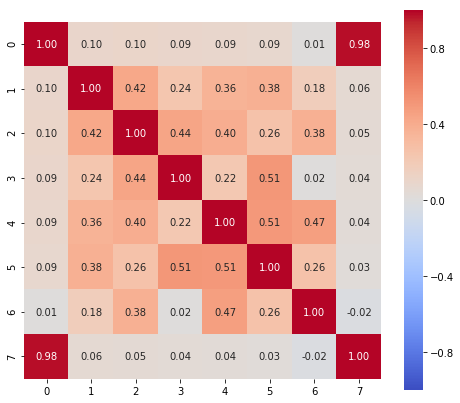

In [0]:
plt.figure(figsize=(8,7))
sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1, vmin=-1, square=True, annot=True, fmt='.2f')



_Obtener columnas altamente correladas_

In [0]:
(corr_matrix['Attack'].abs() > 0.4)

In [0]:
(corr_matrix['Attack'].abs() > 0.9).any()

In [0]:
drop_columns = [c for c in quantitative_vars if (corr_matrix[c].abs() > 0.9).any()]
drop_columns



## Técnicas Gráficas (Opcional)

El método más sencillo de realizar gráficos en Spark es utilizando muestras.

 

__Histogramas y BoxPlots__

In [0]:
susy_df = spark.read.csv(DATA_PATH + 'susy.csv', sep=',', inferSchema=True, header=True)

In [0]:
susy_df.limit(10).toPandas()

,label,lepton1_pt,lepton1_eta,lepton1_phi,lepton2_pt,lepton2_eta,lepton2_phi,missing_energy_magnitude,missing_energy_phi,met_rel,axial_met,m_r,m_tr?,r,mt2,s_r,m_delta_r,dphi_r_b,cos(theta_r1)
0,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
1,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
2,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
3,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859
4,0.0,0.456398,1.099371,1.512453,0.751772,0.638967,-0.742216,0.322601,1.321054,0.169502,0.359941,0.489256,0.416168,0.754829,0.303750,0.461067,0.345541,0.733242,0.186044
5,0.0,0.437818,-1.119883,-1.336823,0.502320,-1.717515,1.017067,0.215619,-0.461200,0.323671,0.173626,0.411898,0.370525,0.798260,0.671369,0.385910,0.515522,0.479110,0.029058
6,0.0,0.571656,0.205696,0.425950,0.578514,0.927399,-1.101478,0.116555,1.549753,0.174421,0.223450,0.523164,0.289889,0.491710,0.334593,0.514246,0.268207,0.315795,0.125728
7,1.0,2.112812,0.742983,-0.330539,0.805253,-0.028887,-1.446679,2.299946,1.450429,2.989110,-1.894770,1.445125,2.548166,1.564721,2.393632,1.554566,2.148468,1.179117,0.688057
8,0.0,1.001869,-0.471788,0.555614,1.233368,1.255548,-1.052491,0.437615,-1.333052,0.326858,-0.111678,1.435708,0.755201,0.466779,0.454541,1.446331,0.592259,1.325197,0.083014
9,0.0,0.840115,0.958249,-0.585658,1.317930,-1.063730,1.246235,0.261865,-0.027341,0.330517,0.183190,1.557298,0.531022,0.302592,0.426702,1.564376,0.338552,1.137456,0.011040


In [0]:
n_rows = susy_df.count()
n_rows

1048575

In [0]:
sample_data = susy_df.select('lepton1_pt').sample(False, fraction=10000/n_rows).toPandas()
sample_data.head(10)

,lepton1_pt
0,1.006098
1,0.514125
2,0.604460
3,0.948203
4,0.779272
5,0.584022
6,0.739532
7,0.824255
8,0.930379
9,0.476953


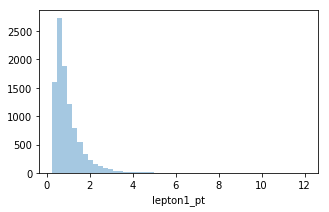

In [0]:
plt.figure(figsize=(5,3))
sns.distplot(sample_data['lepton1_pt'], kde=False)

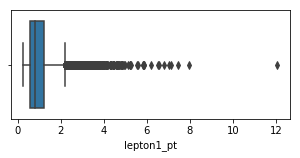

In [0]:
plt.figure(figsize=(5,2))
sns.boxplot(sample_data['lepton1_pt'], orient='h')



__Scatter plot y Side-by-Side BoxPlot__

_Scatter_

In [0]:
sample_data = susy_df.select('lepton1_pt', 'missing_energy_magnitude')\
                     .sample(False, fraction=10000/n_rows).toPandas()
sample_data.head(5)

,lepton1_pt,missing_energy_magnitude
0,1.641748,0.194475
1,1.709806,0.971828
2,1.615013,2.625859
3,0.435538,0.824657
4,1.026801,1.049965


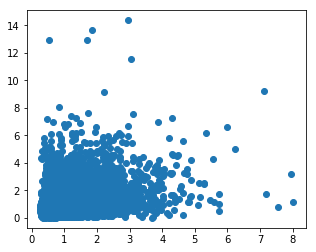

In [0]:
plt.figure(figsize=(5,4))
plt.scatter(sample_data['lepton1_pt'], sample_data['missing_energy_magnitude'])



__Side-by-Side BoxPlot__

In [0]:
sample_data = susy_df.select('lepton1_pt', 'label')\
                     .sample(False, fraction=10000/n_rows).toPandas()

sample_data.head(5)

,lepton1_pt,label
0,0.586191,1.0
1,0.622858,0.0
2,0.749962,0.0
3,0.598661,0.0
4,0.729869,0.0


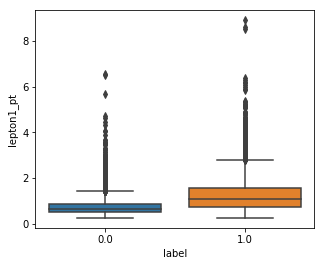

In [0]:
plt.figure(figsize=(5,4))
sns.boxplot(x='label', y='lepton1_pt', data=sample_data, orient='v')



__Barplot__

Es posible precalcular los datos y por tanto no es necesario hacer un sampling.

In [0]:
value_counts = pokemon_df.groupBy('Type 1').count().toPandas()
value_counts

,Type 1,count
0,Water,112
1,Poison,28
2,Steel,27
3,Rock,44
4,Ice,24
5,Ghost,32
6,Fairy,17
7,Psychic,57
8,Dragon,32
9,Flying,4


In [0]:
value_counts = value_counts.sort_values('count')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

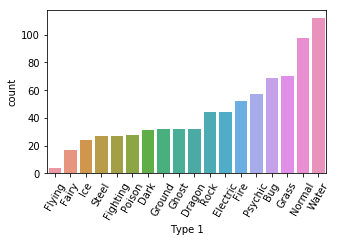

In [0]:
plt.figure(figsize=(5,3))
sns.barplot(value_counts['Type 1'], value_counts['count'])
plt.xticks(rotation=60)



# Valores Atípicos

Una forma muy sencilla de eliminar outliers de forma analítica es aplicando el test de Tukey. Éste dice que se considera valor atípico a todo aquel que **esté fuera** del siguiente rango:

- Valor atípico: $ Q_1 - 1.5\cdot IQR > x > Q_3 + 1.5 \cdot IQR$
- Valor atípico extremo: $Q_1 - 3\cdot IQR > x >Q_3 + 3\cdot IQR$

Vamos a crear una función para identifucar outliers usando el test de Tukey.



_Calcula en rango_

In [0]:
q1, q3 = susy_df.approxQuantile('lepton1_pt', [0.25, 0.75], 0.01)
q1, q3

(0.5675671100616455, 1.192513108253479)

In [0]:
IQR = q3 - q1
IQR

0.6249459981918335

In [0]:
min_thresh = q1 - 1.5 * IQR
max_thresh = q3 + 1.5 * IQR

min_thresh, max_thresh

(-0.36985188722610474, 2.1299321055412292)



_Crea una función._

In [0]:
def remove_tukey_outliers(df, col):
    """
    Returns a new dataframe with outliers removed on column 'col' usting Tukey test
    """
    
    q1, q3 = df.approxQuantile(col, [0.25, 0.75], 0.01)
    IQR = q3 - q1
    
    min_thresh = q1 - 1.5 * IQR
    max_thresh = q3 + 1.5 * IQR
    
    df_no_outliers = df.filter(F.col(col).between(min_thresh, max_thresh))
    
    return df_no_outliers

In [0]:
susy_no_outliers = remove_tukey_outliers(susy_df, 'lepton1_pt')

In [0]:
n_rows_no = susy_no_outliers.count()
perc_outliers = 100 * (n_rows - n_rows_no) / n_rows

In [0]:
print('{} has {:.2f}% outliers'.format('lepton1_pt', perc_outliers))

lepton1_pt has 6.34% outliers
